In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform, pdist
import os
from tqdm import tqdm
import gzip
import ijson
import seaborn as sns
from uncertainties import ufloat, nominal_value, std_dev, ufloat_fromstr, unumpy
from karma import RES_DIR, DATA_DIR

In [2]:
xl_df = pd.read_csv(os.path.join(DATA_DIR, "2020-01-28_Rout_NUP_crosslinking.csv"))
protein_residues = xl_df.protein_residues.str.extract('(\w+)\((\d+)\)-(\w+)\((\d+)\)', expand=True)

_df = xl_df[["p_value"]].copy()
_df = _df.dropna()

_df["significant"] = -np.log10(_df.p_value + 1e-10)  # some p-values are 0, so we have to set a minimum value
_df["protein_1"] = protein_residues[0].str.upper()
_df["residue_1"] = protein_residues[1]
_df["protein_2"] = protein_residues[2].str.upper()
_df["residue_2"] = protein_residues[3]
all_proteins = sorted(set(_df.protein_1).union(_df.protein_2))
significant_df = _df.groupby(["protein_1", "protein_2"]).sum()[["significant"]]
significant_df.sample(10)

significant
protein_1 protein_2             
POM152    POM152      167.001181
NUP192    NUP49        26.104898
NUP188    MLP2          2.500313
POM34     NUP157        6.078140
NUP85     NUP82         8.707744
NSP1      NUP192        9.180456
NUP100    NUP100      137.308281
NUP57     MLP2          1.101275
NIC96     MLP2          3.355561
NUP57     NIC96        53.600407

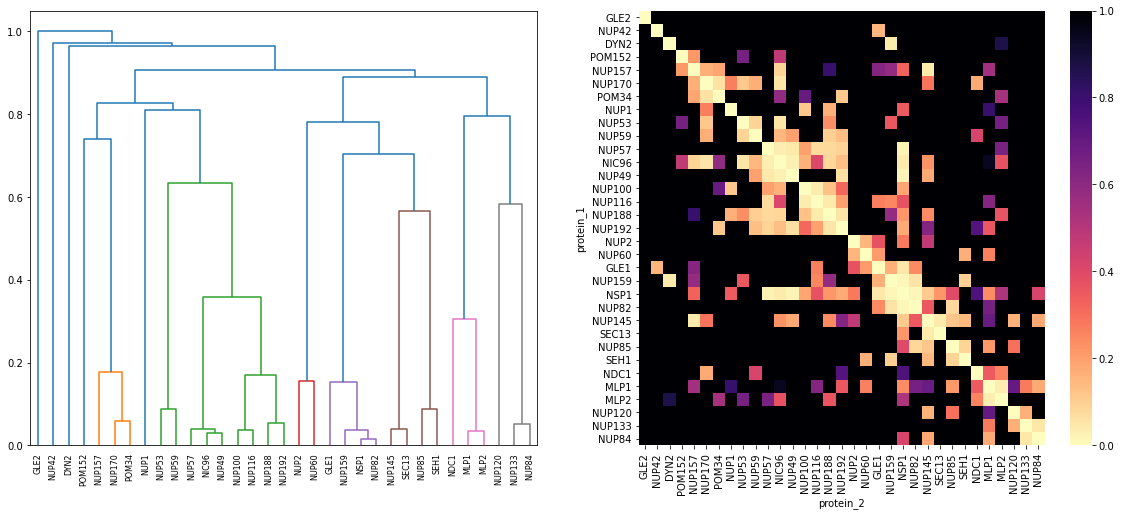

In [3]:
# create an empty DataFrame with all protein pairs:
pair_df = pd.DataFrame(index=pd.MultiIndex.from_product([all_proteins, all_proteins]))
pair_df.index.names = ["protein_1", "protein_2"]
pair_df.reset_index(inplace=True)

# Fill in zeros for the protein pairs with no data, by joining it to an empty
# dataframe (with the full list of indexes) and filling the NaNs with 0.
distance_df = pair_df.join(significant_df[["significant"]], on=["protein_1", "protein_2"], how="left").fillna(0)
distance_df = distance_df.pivot("protein_1", "protein_2", "significant")

distance_df = (distance_df + distance_df.T)/2  # make the matrix symmetric
distance_df = 1.0 / (distance_df + 1.0)  # invert score and make it between 0 and 1
distance_df.head()

D = distance_df.values
np.fill_diagonal(D, 0.0)

Z = hierarchy.linkage(squareform(D), method="average")

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

ax = axs[0]
a = hierarchy.dendrogram(Z, ax=ax)
protein_order = list(map(all_proteins.__getitem__, a["leaves"]))
ax.set_xticklabels(protein_order, rotation=90);

ordered_df = distance_df.copy()
ordered_df = ordered_df.loc[:, protein_order]
ordered_df = ordered_df.loc[protein_order, :]

ax = axs[1]
sns.heatmap(ordered_df, ax=ax, cmap="magma_r");

# Comparing with KARMA clustering results

In [4]:
clusters = {
    "NUP85": ["NUP120", "NUP85", "SEH1"],
    "NUP133": ["NUP133", "NUP145C", "NUP84", "NUP145N", "SEC13"],
    "*NUP53": ["NUP170", "NUP53", "POM152", "POM34", "NUP157", "NUP59", "NUP100", "NUP116", "GLE2"],
    "NUP1": ["NUP1", "NUP60", "NUP2"],
    "NUP159": ["NUP159", "NUP82"],
    "NUP57": ["NUP49", "NUP57", "NIC96", "NUP192"],
    "NUP188": ["NUP188"],
    "*MLP2": ["MLP2"],
    "MLP1": ["MLP1"],
}
# unassigned NUPs : NDC1, NSP1, GLE1, NUP42; (grouping cannot be assigned due to either noisy/lacking data or high dynamic exchange or multiple complexes)
# clusters with no bait are marked with *

protein_to_cluster = {p: c for c in clusters.keys() for p in clusters[c]}

In [5]:
_df = pd.DataFrame(data=[(c, p) for c in clusters.keys() for p in clusters[c]], columns=["cluster", "protein"]).set_index("protein")
pair_df = pd.DataFrame(index=pd.MultiIndex.from_product([_df.index, _df.index]))
pair_df.index.names = ["protein_1", "protein_2"]
pair_df.reset_index(inplace=True)

cluster_df = pair_df.join(_df, on="protein_1", how="right").join(_df, on="protein_2", lsuffix="_2", how="right")
cluster_df["is_clustered"] = (cluster_df.cluster_2 == cluster_df.cluster)
cluster_df = cluster_df.drop(["cluster", "cluster_2"], axis=1)

# drop all the self-pairs
cluster_df = cluster_df[cluster_df.protein_1 != cluster_df.protein_2]

cluster_df = cluster_df.join(significant_df[["significant"]], on=["protein_1", "protein_2"], how="left").fillna(0)
cluster_df.sample(10)

cluster_df

protein_1 protein_2  is_clustered  significant
29      NUP85    NUP120          True     0.000000
58       SEH1    NUP120          True     0.000000
87     NUP133    NUP120         False     0.000000
116   NUP145C    NUP120         False     0.000000
145     NUP84    NUP120         False     0.000000
..        ...       ...           ...          ...
695     NUP57      MLP1         False     0.000000
724     NIC96      MLP1         False     0.000000
753    NUP192      MLP1         False     3.607303
782    NUP188      MLP1         False     0.000000
811      MLP2      MLP1         False    25.870532

[812 rows x 4 columns]

In [6]:
intra_group = cluster_df.loc[cluster_df.is_clustered, "significant"]
inter_group = cluster_df.loc[~cluster_df.is_clustered, "significant"]

In [7]:
p_intra = (intra_group > 0).sum() / intra_group.shape[0]
p_inter = (inter_group > 0).sum() / inter_group.shape[0]

print(f"Change of cross-link inside a cluster {100*p_intra:.1f}%")
print(f"Change of cross-link between clusters {100*p_inter:.1f}%")

Change of cross-link inside a cluster 28.8%
Change of cross-link between clusters 10.4%


In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(intra_group.values, cumulative=True, density=True, histtype="step", bins=200, label="within cluster")
ax.hist(inter_group.values, cumulative=True, density=True, histtype="step", bins=200, label="between cluster")
ax.set_xlabel("sum of -log10(p)")
ax.set_ylabel("cumulative distribution function")
ax.legend(loc="lower right")

# Correlation between distances based on KARMA, versus cross-linking score

In [9]:
DATA_FNAME = os.path.join(
        DATA_DIR,
        "2020-01-15_K1_Evgeny_10NUPs_HQ_protein_consensus_Lysine-corrected+timers_Elad.tsv")
LABELING_COLUMN = "fract.labeling.corr"
TIMER_COLUMN = "NTR.timer.corr"
BEST_TREE_PATH = os.path.join(RES_DIR, "best_fit_tree")

data_df = pd.read_csv(DATA_FNAME, delimiter="\t")
data_df.Time = data_df.Time.str[1:].apply(float)
data_df = data_df[data_df.Time != 0]  # drop the 0 time point which has no data
data_df.rename(columns={"gene": "prey",
                        "Handle": "bait",
                        LABELING_COLUMN: "labeling",
                        TIMER_COLUMN: "timer",
                        }, inplace=True)
data_df.labeling = data_df.labeling
data_df.timer = data_df.timer

time_point = 30

baits = data_df.bait.unique()
mean_data_df = data_df[data_df["Time"] == time_point]
mean_data_df = mean_data_df.groupby(["prey", "bait"]).mean()
mean_data_df = mean_data_df[["labeling"]].reset_index()
mean_data_df = mean_data_df.pivot("prey", "bait", "labeling")

karma_distance_df = pd.DataFrame(
    data=squareform(pdist(mean_data_df.values, metric="correlation")/2),
    index=mean_data_df.index.copy(),
    columns=mean_data_df.index.copy(),
)
karma_distance_df.index.name = "protein_1"
karma_distance_df.columns.name = "protein_2"

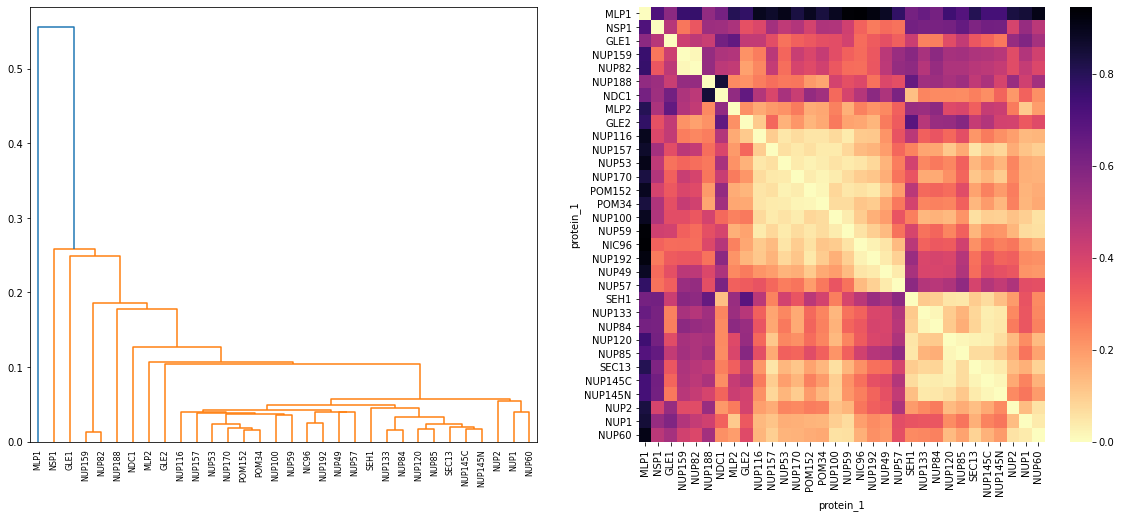

In [10]:
# hierarchical clustering based on KARMA:
Z = hierarchy.linkage(squareform(karma_distance_df.values), method="single")

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

ax = axs[0]
a = hierarchy.dendrogram(Z, ax=ax)
protein_order = karma_distance_df.index[a["leaves"]]
ax.set_xticklabels(protein_order, rotation=90);

ordered_df = karma_distance_df.copy()
ordered_df = ordered_df.loc[:, protein_order]
ordered_df = ordered_df.loc[protein_order, :]

ax = axs[1]
sns.heatmap(ordered_df, ax=ax, cmap="magma_r");

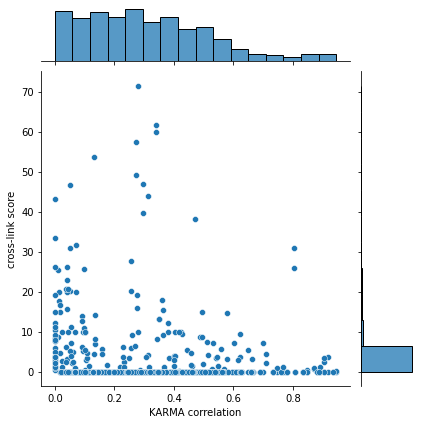

In [11]:
joined_df = pd.merge(karma_distance_df.reset_index().melt(id_vars="protein_1", value_name="karma_distance"),
                     significant_df, on=["protein_1", "protein_2"], how="outer")
joined_df = joined_df[joined_df.protein_1 != joined_df.protein_2].fillna(0)
joined_df.rename(columns={"significant": "cross-link score", "karma_distance": "KARMA correlation"}, inplace=True)

sns.jointplot(x="KARMA correlation", y="cross-link score", data=joined_df)